In [1]:
# Import Relevant Packages
import tweepy
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from requests.structures import CaseInsensitiveDict
import math
import datetime
import rfc3339
import iso8601

In [2]:
# Read API keys
with open("/Users/sihanzhang/Desktop/IEOR4524/twitter_credentials_v2.txt",'r') as token_file:
    contents = token_file.read().split('\n') # put them in different lines
    API_KEY = contents[0]
    API_KEY_SECRET = contents[1]
    BEARER_TOKEN = contents[2]
    ACCESS_TOKEN = contents[3]
    ACCESS_TOKEN_SECRET = contents[4]

In [3]:
# Define a function to create Twitter API v2 Client
def GetClient():
    client = tweepy.Client(bearer_token=BEARER_TOKEN,
                           consumer_key=API_KEY,
                           consumer_secret=API_KEY_SECRET,
                           access_token=ACCESS_TOKEN,
                           access_token_secret=ACCESS_TOKEN_SECRET)
    return client

In [4]:
# Find the User IDs
def GetUserID(client, user_name):
    
    user_id = client.get_user(username = user_name).data.id
    
    return user_id

In [5]:
user_names = ['elerianm', 'PeterSchiff', 'larryfink', 'CathieDWood', 'chamath', 'BillHwang6', 'BurryArchive']
user_ids = []
for name in user_names:
    user_ids.append(GetUserID(GetClient(), name))
user_ids

[332617373,
 56562803,
 55306695,
 2361631088,
 3291691,
 1378547613725786121,
 1318028333041504256]

In [6]:
# Function used to transform a datetime object into RFC 3339 form
def get_date_string(date):
    return rfc3339.rfc3339(date)

# Function used to transform RFC 3339 form timestamp into a datetime object
def get_date_object(date_string):
    return iso8601.parse_date(date_string)

In [7]:
# Create DateTime objects
time_now = datetime.datetime.utcnow()
a_week_ago=time_now - datetime.timedelta(days=7)
a_month_ago=time_now - datetime.timedelta(days=30)
a_year_ago=time_now - datetime.timedelta(days=360)

# Transform DateTime objects into the RFC 3339 form for Twitter API v2 to parse
time_now = get_date_string(time_now)
a_week_ago = get_date_string(a_week_ago)
a_month_ago = get_date_string(a_month_ago)
a_year_ago = get_date_string(a_year_ago)

print('time_now:', time_now)
print('a_week_ago:', a_week_ago)
print('a_month_ago:', a_month_ago)
print('a_year_ago:', a_year_ago)

time_now: 2022-05-06T01:07:22-04:00
a_week_ago: 2022-04-29T01:07:22-04:00
a_month_ago: 2022-04-06T01:07:22-04:00
a_year_ago: 2021-05-11T01:07:22-04:00


## Functions

In [8]:
# The function feeds the User IDs and the DateTime object into the command Client.get_users_tweets 
# and use Paginator to get all the Tweet IDs of the tweets posted by the selected users. 
# Input parameters including end time and limit are also incorporated into this function
def SearchUserTweets(client, user_id, limit, start_time, end_time = None):
    
    twitter_ids = []
    
    if end_time != None:
        for tweet in tweepy.Paginator(client.get_users_tweets, id=user_id, 
                                      start_time = start_time, end_time = end_time, 
                                      max_results=100).flatten(limit=limit):
            twitter_ids.append(tweet.id)
    else:
        for tweet in tweepy.Paginator(client.get_users_tweets, id=user_id, 
                                      start_time = start_time,
                                      max_results=100).flatten(limit=limit):
            twitter_ids.append(tweet.id)        

    return twitter_ids

In [9]:
# The function uses the Tweet IDs as the search query parameter of the command requests.get 
# to obtain more detailed information about each tweet
def GetTweets(client, twitter_ids):
    dict_metrics = {'author_id':[], 'tweet_id':[], 'created_at':[], 'text':[], 
                    'retweet':[], 'like':[], 'reply':[], 'quote':[]}

    url = "https://api.twitter.com/2/tweets?ids={twitter_ids}".format(twitter_ids=twitter_ids) + \
    "&tweet.fields=attachments,author_id,context_annotations,conversation_id,created_at,entities," + \
    "geo,id,in_reply_to_user_id,lang,possibly_sensitive,public_metrics,referenced_tweets," + \
    "reply_settings,source,text,withheld"

    headers = CaseInsensitiveDict()
    headers["Authorization"] = "Bearer "+ BEARER_TOKEN

    resp = requests.get(url, headers=headers)
    if resp.status_code == 200:
        results = resp.json()['data']
        for i in range(len(results)):
            if results[i]['lang'] == 'en' and re.search('RT ', results[i]['text']) == None:
                dict_metrics['author_id'].append(results[i]['author_id'])
                dict_metrics['tweet_id'].append(results[i]['id'])
                dict_metrics['created_at'].append(get_date_object(results[i]['created_at']))
                dict_metrics['text'].append(results[i]['text'])
                dict_metrics['retweet'].append(results[i]['public_metrics']['retweet_count'])
                dict_metrics['like'].append(results[i]['public_metrics']['like_count'])
                dict_metrics['reply'].append(results[i]['public_metrics']['reply_count'])
                dict_metrics['quote'].append(results[i]['public_metrics']['quote_count'])      
        
        return dict_metrics

In [10]:
# When we use Tweet IDs as the search query parameter of the command requests.get,
# there can be as many as 100 Tweet IDs in one request.
# So, we first split the Tweet IDs into groups of size 100 and convert them to strings

# Split the Tweet IDs into groups of size 100
lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]

In [11]:
# Convert Tweet IDs to strings
def convert(list):

    res = ",".join(map(str, list))
      
    return res

## Data of the past year

In [12]:
tweet_ids_year = []
for user_id in user_ids:
    tweet_ids_year.extend(SearchUserTweets(GetClient(), user_id, 5000, a_year_ago))
# tweet_ids_year

In [13]:
len(tweet_ids_year)

6790

In [14]:
lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
tweet_ids_year_strings = lol(tweet_ids_year, 100)

In [15]:
tweet_ids_year_100 = []
for i in range(len(tweet_ids_year_strings)):
    
    tweet_ids_year_100.append(convert(tweet_ids_year_strings[i]))
# tweet_ids_year_100

In [16]:
df_metrics_year = pd.DataFrame({'author_id':[], 'tweet_id':[], 'created_at':[], 'text':[], 'retweet':[], 'like':[], 'reply':[], 'quote':[]})
for i in range(len(tweet_ids_year_100)):
    df_metrics_year = pd.concat([df_metrics_year, pd.DataFrame(GetTweets(GetClient(), tweet_ids_year_100[i]))], ignore_index=True)
df_metrics_year

,author_id,tweet_id,created_at,text,retweet,like,reply,quote
0,332617373,1522295066529837057,2022-05-05 19:20:01+00:00,Not just a big selloff in #stocks and #bonds\n...,62.0,301.0,41.0,3.0
1,332617373,1522292864406986757,2022-05-05 19:11:16+00:00,From Bloomberg.\n\nGoes counter to what Federa...,35.0,121.0,26.0,9.0
2,332617373,1522287044965421058,2022-05-05 18:48:08+00:00,"From the @FT column by @gilliantett on ""The #F...",43.0,196.0,35.0,7.0
3,332617373,1522258540164964352,2022-05-05 16:54:52+00:00,An illustration of the blame game which sees f...,13.0,79.0,7.0,3.0
4,332617373,1522254580268081152,2022-05-05 16:39:08+00:00,It’s worth listening to/reading the remarks ma...,16.0,135.0,18.0,2.0
...,...,...,...,...,...,...,...,...
5572,3291691,1396299152103862275,2021-05-23 02:57:14+00:00,@investoRotsevni Next Wednesday…sorry for the ...,1.0,30.0,7.0,1.0
5573,3291691,1396216735305322496,2021-05-22 21:29:44+00:00,Congrats to the entire @virgingalactic team on...,213.0,4007.0,3.0,123.0
5574,3291691,1394451978848129024,2021-05-18 00:37:14+00:00,Calling $IPOE shareholders: make your voice he...,180.0,1733.0,460.0,60.0
5575,3291691,1392691266605879298,2021-05-13 04:00:47+00:00,Pod up! Cold intro v strong. https://t.co/jYaQ...,45.0,1110.0,314.0,26.0


## Assign Weights

In [17]:
# Calculate weights for tweets
df_metrics_year['weight_raw'] = round(0.2*df_metrics_year['retweet'] + 0.1*df_metrics_year['like'] 
                                      + 0.3*df_metrics_year['reply'] + 0.4*df_metrics_year['quote'])
df_metrics_year_active = df_metrics_year[df_metrics_year['weight_raw']>0]
df_metrics_year_active = df_metrics_year_active.reset_index(drop=True)
df_metrics_year_active['weight'] = round(np.log(df_metrics_year_active['weight_raw'])).astype(int)

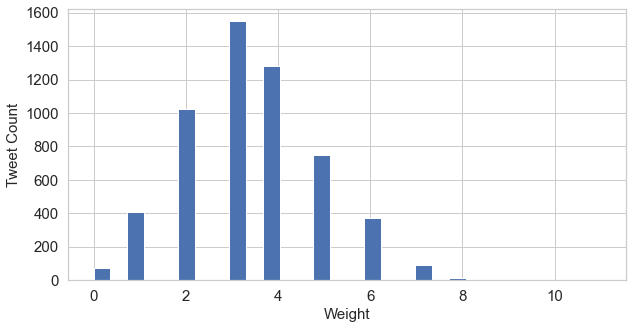

In [18]:
# The distribution of the calculated weights for tweets
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")
hist = df_metrics_year_active['weight'].hist(bins=30)
hist.set_xlabel("Weight",fontsize=15)
hist.set_ylabel("Tweet Count",fontsize=15)
hist.tick_params(labelsize=15)

## Find out Month Info

In [19]:
# Find out which month and year the tweet belongs to
df_metrics_year_active['year'] = pd.DatetimeIndex(df_metrics_year_active['created_at']).year
df_metrics_year_active['month'] = pd.DatetimeIndex(df_metrics_year_active['created_at']).month
df_metrics_year_active['time'] = df_metrics_year_active['year'].astype(str).str.cat(
    df_metrics_year_active['month'].astype(str), sep='-')

In [20]:
unique_months = list(df_metrics_year_active['time'].unique())
num_unique_months = len(df_metrics_year_active['time'].unique())

In [21]:
df_metrics_year_active.head()

,author_id,tweet_id,created_at,text,retweet,like,reply,quote,weight_raw,weight,year,month,time
0,332617373,1522295066529837057,2022-05-05 19:20:01+00:00,Not just a big selloff in #stocks and #bonds\n...,62.0,301.0,41.0,3.0,56.0,4,2022,5,2022-5
1,332617373,1522292864406986757,2022-05-05 19:11:16+00:00,From Bloomberg.\n\nGoes counter to what Federa...,35.0,121.0,26.0,9.0,31.0,3,2022,5,2022-5
2,332617373,1522287044965421058,2022-05-05 18:48:08+00:00,"From the @FT column by @gilliantett on ""The #F...",43.0,196.0,35.0,7.0,42.0,4,2022,5,2022-5
3,332617373,1522258540164964352,2022-05-05 16:54:52+00:00,An illustration of the blame game which sees f...,13.0,79.0,7.0,3.0,14.0,3,2022,5,2022-5
4,332617373,1522254580268081152,2022-05-05 16:39:08+00:00,It’s worth listening to/reading the remarks ma...,16.0,135.0,18.0,2.0,23.0,3,2022,5,2022-5


In [22]:
# Get the monthly data
df_metrics_month_active = df_metrics_year_active[df_metrics_year_active['time']==unique_months[0]]
df_metrics_month_active.reset_index(inplace = True)
df_metrics_month_active = df_metrics_month_active.drop(['index'], axis=1)
# df_metrics_month_active

## Text Cleaning

In [23]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
import pprint

In [24]:
data = df_metrics_year_active.copy()

# ASCII removal
data['text'] = data['text'].apply(lambda x: x.encode("ascii", "ignore").decode()) # Non-ASCII processing

# Number removal
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+','', x)) 

In [25]:
data["text"] = data["text"].astype(str)

# Lowercase
data['text_preprocessing'] = data['text'].str.lower()

# URL removal
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

data['text_preprocessing'] = data['text_preprocessing'].apply(lambda text: remove_urls(text))

# data.head()

In [26]:
# Especially for Social Media Texts
# EMOTICON, EMOJI, CHAT CONVERSION & Spelling Correction

# Conversion of Emoticon to Words
fr = open("EMOTICONS.txt",'r+')
EMOTICONS = eval(fr.read())
fr.close()
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

# Conversion of Emoji to Words
fr = open("EMOJIS.txt",'r+')
UNICODE_EMO = eval(fr.read())   
fr.close()
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text

# Chat Words Conversion
f = open("/Users/sihanzhang/Desktop/IEOR4524/chat_conversion.txt",encoding = "utf-8")
chat_words_str = f.read()
f.close()

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)
            
# Remove emoji and special characters
# def remove_emoji(string):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

# Spelling Correction
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

data['text_correct'] = data['text_preprocessing'].apply(lambda text: convert_emoticons(text))
print('Emoticons finished')
data['text_correct'] = data['text_correct'].apply(lambda text: convert_emojis(text))
print('Emojis finished')
data['text_correct'] = data['text_correct'].apply(lambda text: chat_words_conversion(text))
print('Chat Word finished')
data['text_correct'] = data['text_correct'].apply(lambda text: correct_spellings(text))
print('Spelling Correction finished')
# data.head()

Emoticons finished
Emojis finished
Chat Word finished
Spelling Correction finished


In [27]:
# Punctuation: noise deletion
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
# for twitter
data["text_wo_punct"] = data["text_correct"].apply(lambda text: remove_punctuation(text))
# data["text_wo_punct"] = data["text_preprocessing"].apply(lambda text: remove_punctuation(text))

# Stopwords removal
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# data["text_wo_stop"] = data["text_wo_punct"].apply(lambda text: remove_stopwords(text))
data["text_wo_stop"] = data["text_correct"].apply(lambda text: remove_stopwords(text))

# data.head()

In [28]:
# Stemming * Lemmatizing: choose one of the two methods
# Stemming
import nltk 
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
data["text_stemmed"] = data["text_wo_stop"].apply(lambda text: stem_words(text))

# Lemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
data["text_lemmatized"] = data["text_wo_stop"].apply(lambda text: lemmatize_words(text))
data.head()

,author_id,tweet_id,created_at,text,retweet,like,reply,quote,weight_raw,weight,year,month,time,text_preprocessing,text_correct,text_wo_punct,text_wo_stop,text_stemmed,text_lemmatized
0,332617373,1522295066529837057,2022-05-05 19:20:01+00:00,Not just a big selloff in #stocks and #bonds\n...,62.0,301.0,41.0,3.0,56.0,4,2022,5,2022-5,not just a big selloff in #stocks and #bonds\n...,not just a big selloff in stocks and bonds #cr...,not just a big selloff in stocks and bonds cry...,big selloff stocks bonds #cryptocurrencies als...,big selloff stock bond #cryptocurr also lot pr...,big selloff stock bond #cryptocurrencies also ...
1,332617373,1522292864406986757,2022-05-05 19:11:16+00:00,From Bloomberg.\n\nGoes counter to what Federa...,35.0,121.0,26.0,9.0,31.0,3,2022,5,2022-5,from bloomberg.\n\ngoes counter to what federa...,from bloomberg. goes counter to what federal r...,from bloomberg goes counter to what federal re...,bloomberg. goes counter federal reserve chair ...,bloomberg. goe counter feder reserv chair powe...,bloomberg. go counter federal reserve chair po...
2,332617373,1522287044965421058,2022-05-05 18:48:08+00:00,"From the @FT column by @gilliantett on ""The #F...",43.0,196.0,35.0,7.0,42.0,4,2022,5,2022-5,"from the @ft column by @gilliantett on ""the #f...",from the aft column by @gilliantett on the fed...,from the aft column by gilliantett on the fed ...,aft column @gilliantett fed owes american peop...,aft column @gilliantett fed owe american peopl...,aft column @gilliantett feed owes american peo...
3,332617373,1522258540164964352,2022-05-05 16:54:52+00:00,An illustration of the blame game which sees f...,13.0,79.0,7.0,3.0,14.0,3,2022,5,2022-5,an illustration of the blame game which sees f...,an illustration of the blame game which sees f...,an illustration of the blame game which sees f...,illustration blame game sees fingers pointed #...,illustr blame game see finger point #federalre...,illustration blame game see finger point #fede...
4,332617373,1522254580268081152,2022-05-05 16:39:08+00:00,Its worth listening to/reading the remarks mad...,16.0,135.0,18.0,2.0,23.0,3,2022,5,2022-5,its worth listening to/reading the remarks mad...,its worth listening treading the remarks made ...,its worth listening treading the remarks made ...,worth listening treading remarks made today an...,worth listen tread remark made today andrew ba...,worth listen tread remark make today andrew ba...


In [29]:
def strip(text):
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    striptext = striptext.replace('RT ', '')
    return striptext

In [30]:
# Prepare texts for Gensim (No need to do most of the data cleaning)
for k in range(num_unique_months):
    exec(f'gensim_text_past{k}months = ""')
    df_month = data[data['time']==unique_months[k]]
    df_month.reset_index(inplace = True)
    for i in range(len(df_month)):
        tweet = re.sub(r'http\S+', '', df_month['text'][i]).rstrip()
        tweet = re.sub(r'@\S+', '', tweet).rstrip()
        if re.search(r'[?.!]$', tweet) is None:
            tweet = tweet + '.'
        tweet = tweet + ' '
        exec(f'gensim_text_past{k}months = gensim_text_past{k}months + tweet*df_month["weight"][i]')
        exec(f'gensim_text_past{k}months = strip(gensim_text_past{k}months)')

In [31]:
# Prepare texts for TF-IDF
for k in range(num_unique_months):
    exec(f'striptext_past{k}months = ""')
    df_month = data[data['time']==unique_months[k]]
    df_month.reset_index(inplace = True)
    for i in range(len(df_month)):
        tweet = df_month['text_wo_stop'][i]
#         if re.search(r'[?.!]$', tweet) is None:
#             tweet = tweet + '.'
#         tweet = tweet + ' '
        exec(f'striptext_past{k}months = striptext_past{k}months + tweet*df_month["weight"][i]')

## Gensim

In [32]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize,word_tokenize 
import gensim.summarization

In [33]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [34]:
for k in range(num_unique_months):
    exec(f'gensim_past{k}months = gensim.summarization.keywords(gensim_text_past{k}months, words = 10, scores = True, lemmatize = True)')

In [35]:
# I tried to use lemmatize_stemming, but it will transform fed to feed and rates to rat
# So, I have to manually create the list below
inflation_list = ['inflation', 'inflate', 'inflations', 'inflates', 'inflat', 'inflated']
bitcoin_list = ['bitcoin', 'bitcoins', 'bitcoiner', 'bitcoiners']
gold_list = ['gold', 'golds']
fed_list = ['fed', 'feds']
policy_list = ['policy', 'policies']
job_list = ['job', 'jobs']
government_list = ['government', 'governments']
supply_list = ['supply', 'supplies']
powell_list = ['powell', 'powells']
useless_list = ['market', 'marketed', 'marketable', 'markets', 'marketing',
                'investor', 'invested', 'invest', 'investments', 'investors',
                'rate', 'rates', 'rating', 'ratings',
                'economy', 'economies', 'economics', 'economically', 'economical', 'economys', 'economic',
                'governance', 'govern',
                'pricing', 'prices', 'priced', 'price',
                'stocks', 'stock', 'bond',
                'new', 'news', 
                'rises',  'growth', 'tapered', 'taper',
                'years', 'year', 'today', 'todays', 'july', 'timing',
                'includes', 'included', 
                'higher', 'high', 'highs',
                'thank', 'thanks',
                'risking', 'risks',
                'like', 'likes', 'likely', 
                'real', 'goodness', 'data', 'expect', 'even', 'one', 'us', 
                'money', 'financials', 'expects', 'actually', 'people', 'traded',
                'buy', 'buys', 'continuing', 'globally', 'yes', 'timely', 
                'banking', 'econtwitter', 'transitory', 'actual', 'value', 'dont', 'that'
                ]

In [36]:
# Apply the conversion with lists above
for k in range(num_unique_months):
    exec(f'list_in_use = gensim_past{k}months')
    list_del = []
    for i in range(len(list_in_use)):
        word = list_in_use[i][0]
        if word in useless_list:
            list_del.append(i)
        else:
            if word in inflation_list:
                word = inflation_list[0]
            elif word in bitcoin_list:
                word = bitcoin_list[0] 
            elif word in fed_list:
                word = fed_list[0]             
            elif word in policy_list:
                word = policy_list[0]            
            elif word in job_list:
                word = job_list[0] 
            elif word in government_list:
                word = government_list[0]
            elif word in supply_list:
                word = supply_list[0] 
            elif word in gold_list:
                word = gold_list[0] 
            elif word in powell_list:
                word = powell_list[0] 
            list_in_use[i] = (word, list_in_use[i][1])
    
    for index in sorted(list_del, reverse=True):
        del list_in_use[index]
    
    exec(f'gensim_past{k}months = list_in_use')

In [37]:
# Construct a dataframe for every month respectively
for k in range(num_unique_months):
    month = unique_months[k]
    exec(f'df_wordscore{k} = pd.DataFrame(gensim_past{k}months, columns=["word", "{month}"])')
    exec(f'df_wordscore = df_wordscore{k}.copy()')

In [38]:
# Merge the dataframes of different months
for k in reversed(range(num_unique_months)):
    exec(f'df_wordscore = df_wordscore.merge(df_wordscore{k}, how="outer")')

In [39]:
# Arrange the merged dataframe for the line plots
df_wordscore = df_wordscore.fillna(0)
df_wordscore_line = df_wordscore.transpose()
df_wordscore_line.columns = df_wordscore_line.iloc[0]
df_wordscore_line = df_wordscore_line.drop(df_wordscore_line.index[0])

In [40]:
# Round the number up
import math
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [41]:
# Get a proper limit on y-axis using round up on the max score
ylimit = round_up(df_wordscore_line.max().max(),1)

# Find out how many rows would be proper for the subplots
num_columns = len(df_wordscore_line.columns)
column = 2
if num_columns%2 == 0:
    row = int(num_columns/2)
else:
    row = int(num_columns/2)+1

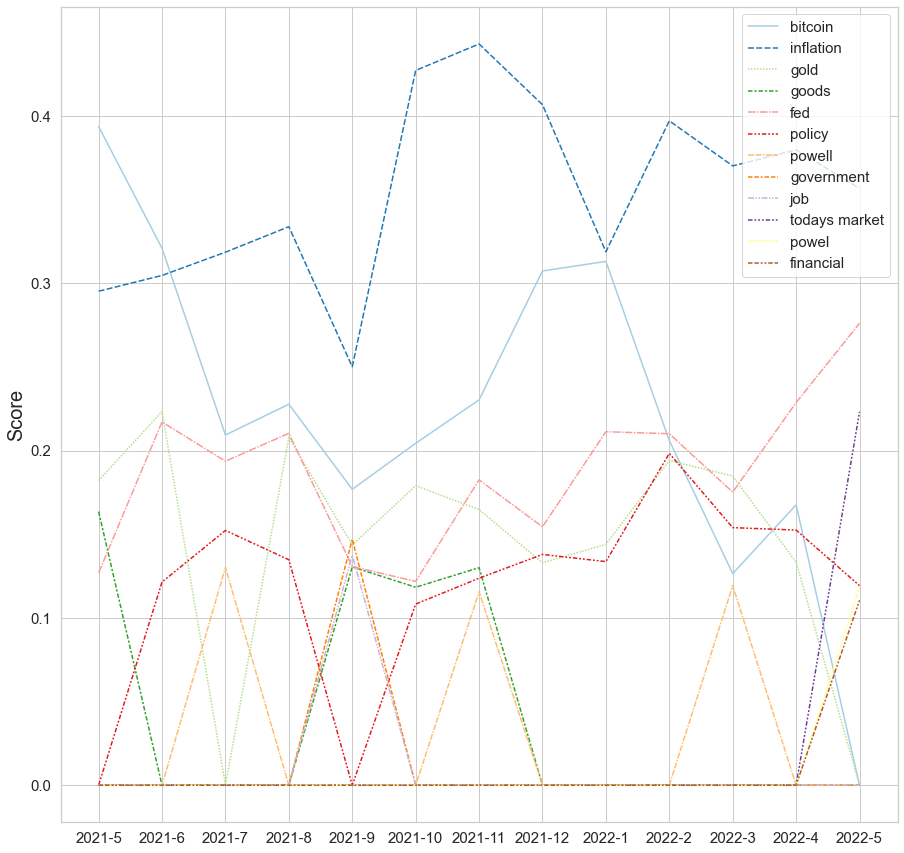

In [42]:
# The line plot showing the trend of multiple words in one graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style("whitegrid")

ax = sns.lineplot(data=df_wordscore_line, palette=sns.color_palette('Paired', n_colors=num_columns))
ax.set_ylabel("Score",fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

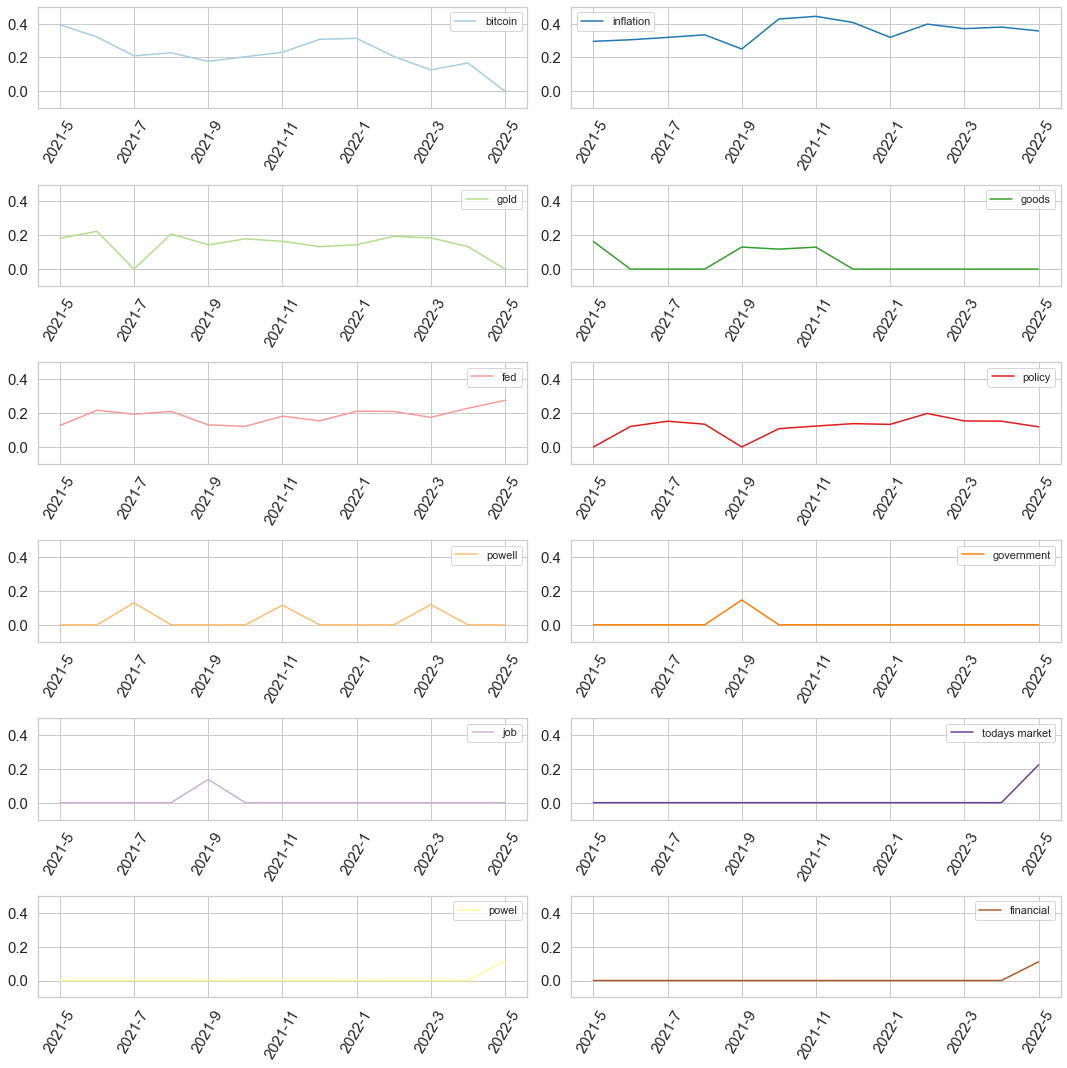

In [43]:
# The multiple subplots showing the trend for each keyword
sns.set_style("whitegrid")
sns.set_palette("Paired")
fig, ax = plt.subplots(row, column, figsize=(15, 15), tight_layout=True)
df_wordscore_line.plot(ax=ax.flatten()[:num_columns], subplots=True, rot=60, ylim = [-0.1, ylimit], fontsize=15)

In [44]:
# Obtain summary sentences for each month
for k in range(num_unique_months):
    month = unique_months[k]
    exec(f'summary = gensim.summarization.summarize(gensim_text_past{k}months, word_count=30)')
    print(f'{month}:')
    print(summary)
    print()

2022-5:
I find it rather fascinating that, as judged by the tick-by-tick price action in financial #markets (#stocks and #bonds), todays #FederalReserve policy actions and signals all came down to one thing: Chair #Powell ruling out a  basis point rate increase.

2022-4:
. charts on  of the week's dominant themes: How high will US inflation get to (.% being the consensus forecast for the March print);and The extent to which the ongoing change in the #Fed's policy regime will contribute to the restoration of positive -year real yields.

2022-3:
Thanks   My sense: #markets feel that, despite what Chair #Powell said, the #Fed is more likely to risk higher inflation for longer than risk hitting the policy brakes too hard and pushing the economy into a recession.

2022-2:
.#Oil above $ is but one of notable #markets' reactions to #Russia's attack on #Ukraine--what until today too many saw as just a tail risk The resulting stagflationary influences for the #economy come at a time when Fed po

## TF-IDF

In [45]:
articles = []
for k in range(num_unique_months):
    exec(f'articles.append(striptext_past{k}months)')   

In [46]:
# Get the datebymonth column
df_tfidf= df_wordscore_line.rename_axis(None, axis=1)
df_tfidf.reset_index(inplace = True)
df_tfidf.columns = df_tfidf.columns.str.replace('index', 'datebymonth')
raw_df = df_tfidf['datebymonth']
raw_df

0      2021-5
1      2021-6
2      2021-7
3      2021-8
4      2021-9
5     2021-10
6     2021-11
7     2021-12
8      2022-1
9      2022-2
10     2022-3
11     2022-4
12     2022-5
Name: datebymonth, dtype: object

In [47]:
# Calculate the score for each word in each month
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(articles)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
idf_df = pd.concat([raw_df, df],axis=1) 
idf_df

,datebymonth,__spectral,_biggiecalls,_blindbutalive,_crypto_oracle_,_dima_m_,_john__,_mikekim_,_pow_,_ruchiragarwal,...,zerosuccessfully,zhangyang,zip,zipanother,zippowell,zndtoshi,zone,zoom,zoompianotutor,zuckerberg
0,2021-5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002171,0.000000
2,2021-7,0.000000,0.000000,0.000000,0.000000,0.00917,0.000000,0.000000,0.003668,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005610,0.003450,0.000000,0.000000
3,2021-8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.002187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.010249,0.000000,0.000000,0.000000,0.002275,0.002799,0.000000,0.000000
5,2021-10,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2021-11,0.021783,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2021-12,0.000000,0.000000,0.000000,0.000000,0.00000,0.007212,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005515,0.000000,0.000000,0.012021
8,2022-1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009486,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019827,0.000000,0.000000
9,2022-2,0.000000,0.002379,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [48]:
# Find out the 10 words with highest scores
tf_df = idf_df.groupby('datebymonth',as_index=False).mean()
for i in range(1, 11):
    exec(f'tf_df["{i}_idx"] = df.T.apply(lambda x: x.nlargest({i}).idxmin())')
tf_df_line = tf_df[['datebymonth','1_idx','2_idx','3_idx','4_idx','5_idx',
                    '6_idx', '7_idx','8_idx','9_idx','10_idx']].copy()
list_keywords_raw = []
for i in range(1, 11):
    exec(f'list_keywords_raw.extend(list(tf_df_line["{i}_idx"].unique()))')
list_keywords_raw = list(set(list_keywords_raw))
# list_keywords_raw

In [49]:
# Apply the conversion with lists mentioned before
list_keywords = ['datebymonth']
for word in list_keywords_raw:
    if word in useless_list:
        pass
    else:
        if word in inflation_list:
            word = inflation_list[0]
        elif word in bitcoin_list:
            word = bitcoin_list[0] 
        elif word in fed_list:
            word = fed_list[0]             
        elif word in policy_list:
            word = policy_list[0]            
        elif word in job_list:
            word = job_list[0] 
        elif word in government_list:
            word = government_list[0]
        elif word in supply_list:
            word = supply_list[0] 
        elif word in gold_list:
            word = gold_list[0] 
        elif word in powell_list:
            word = powell_list[0] 
        list_keywords.append(word)

In [50]:
# Get the dataframe for line plots
df_needed = idf_df[list_keywords].copy()
df_needed.set_index('datebymonth', inplace = True)
df_needed.index.name = None
df_needed

,policy,gold,bitcoin,elonmusk,federalreserve,fed,slavery,russia,inflation,financial,ukraine,michael_saylor,government
2021-5,0.085295,0.043595,0.087191,0.021863,0.102354,0.253990,0.000000,0.032093,0.432162,0.106145,0.000000,0.000000,0.056863
2021-6,0.101716,0.117195,0.187954,0.054200,0.045699,0.278615,0.000000,0.009984,0.431189,0.069285,0.026928,0.000000,0.058966
2021-7,0.089644,0.184891,0.161857,0.000000,0.037352,0.226600,0.000000,0.127538,0.369159,0.051670,0.189524,0.000000,0.056028
2021-8,0.139596,0.210136,0.251718,0.000000,0.039354,0.322258,0.000000,0.149608,0.433637,0.042324,0.180846,0.000000,0.042324
2021-9,0.099480,0.123719,0.471646,0.004369,0.040398,0.270161,0.000000,0.003420,0.314094,0.043933,0.000000,0.000000,0.031308
2021-10,0.096538,0.185195,0.361853,0.000000,0.052538,0.233136,0.000000,0.000000,0.407167,0.036120,0.000000,0.000000,0.047284
2021-11,0.106209,0.207040,0.256784,0.023261,0.047055,0.272244,0.000000,0.000000,0.445674,0.041677,0.000000,0.000000,0.082009
2021-12,0.085689,0.140367,0.278286,0.005883,0.031827,0.212999,0.000000,0.000000,0.434974,0.022850,0.000000,0.044216,0.074264
2022-1,0.030053,0.120211,0.222176,0.000000,0.032199,0.193197,0.000000,0.000000,0.275842,0.042933,0.000000,0.009086,0.148117
2022-2,0.082375,0.184940,0.246318,0.000000,0.040380,0.340807,0.000000,0.000000,0.344845,0.053302,0.000000,0.076573,0.050879


In [51]:
# Get a proper limit on y-axis using round up on the max score
ti_ylimit = round_up(df_needed.max().max(),1)

# Find out how many rows would be proper for the subplots
ti_num_columns = len(df_needed.columns)
ti_column = 2
if ti_num_columns%2 == 0:
    ti_row = int(ti_num_columns/2)
else:
    ti_row = int(ti_num_columns/2)+1

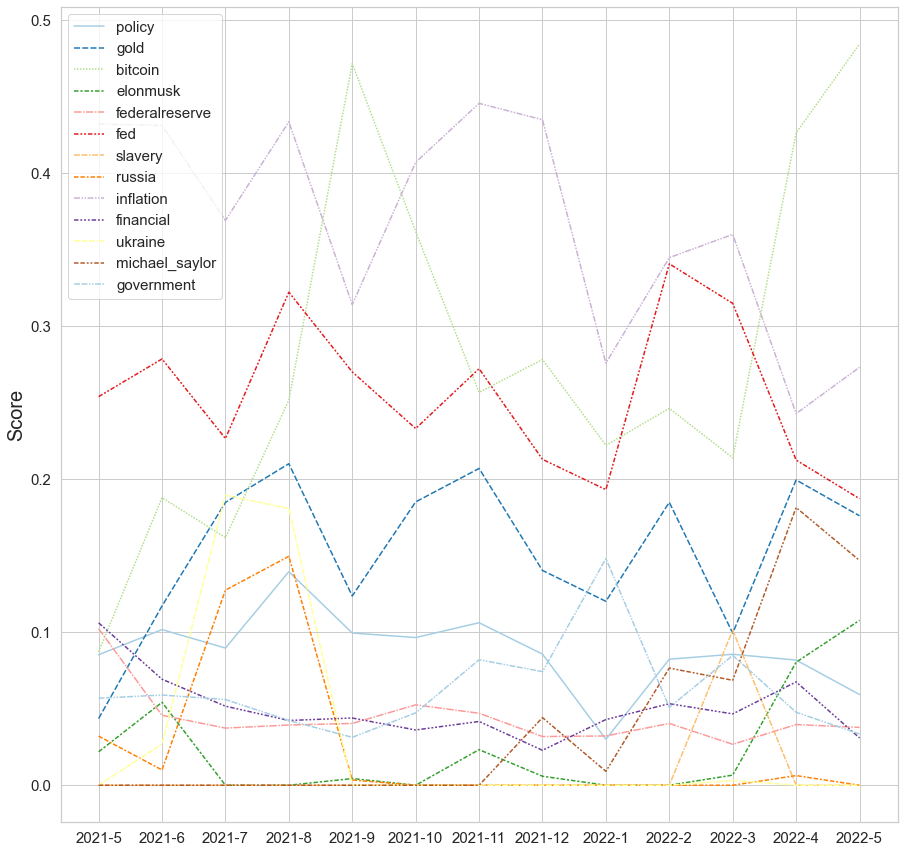

In [52]:
# The line plot showing the trend of multiple words in one graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style("whitegrid")

ax = sns.lineplot(data=df_needed, palette=sns.color_palette('Paired', n_colors=ti_num_columns))
ax.set_ylabel("Score",fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

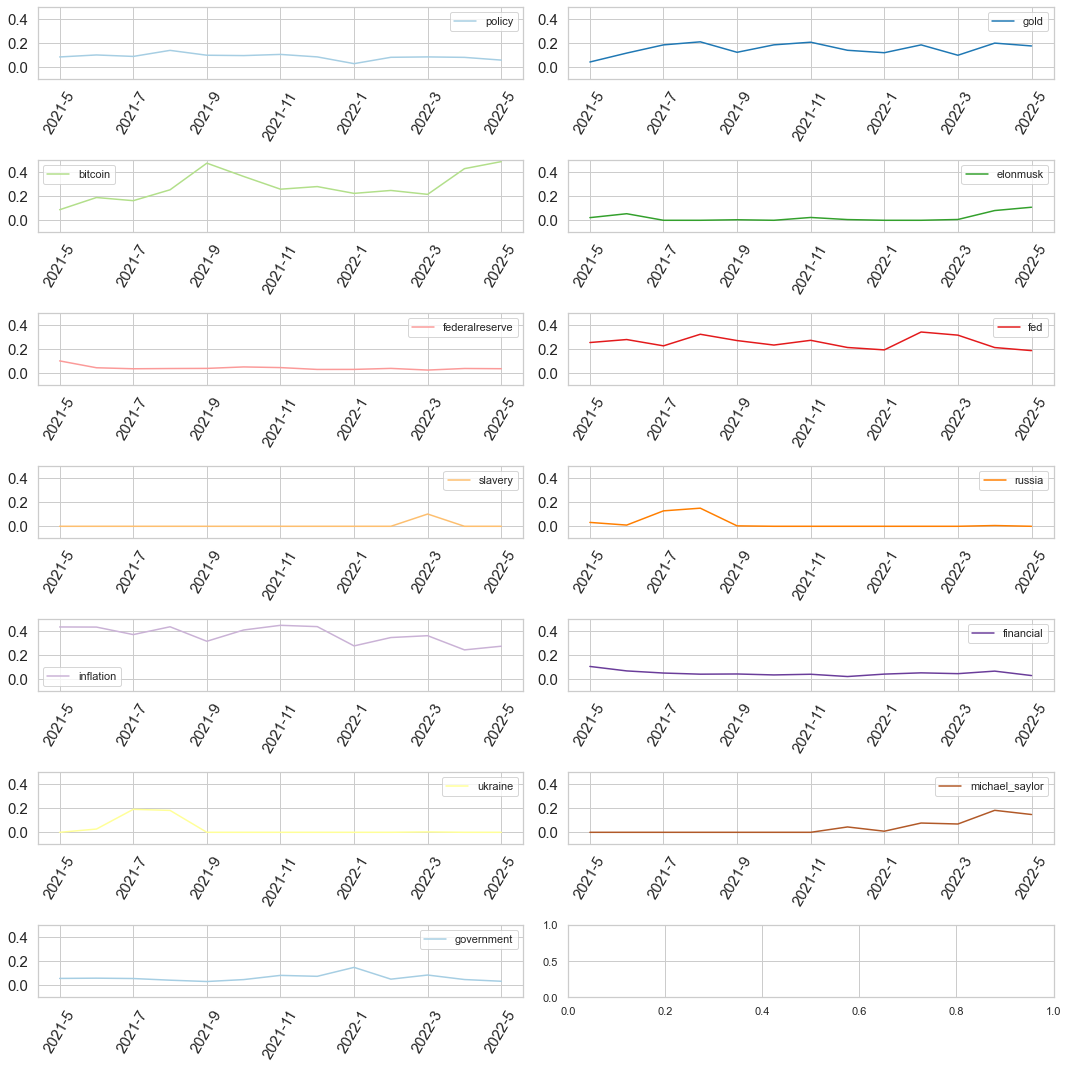

In [53]:
# The multiple subplots showing the trend for each keyword
sns.set_style("whitegrid")
sns.set_palette("Paired")
fig, ax = plt.subplots(ti_row, ti_column, figsize=(15, 15), tight_layout=True)
df_needed.plot(ax=ax.flatten()[:ti_num_columns], subplots=True, rot=60, ylim = [-0.1, ti_ylimit], fontsize=15)

## LDA for Past-Month Data

In [54]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

In [55]:
# Join tweet texts posted by the same author and form a list of documents
def build_texts(author_id, df_build):
    text = ""
    for i in range(len(df_build)):
        tweet = re.sub(r'http\S+', '', df_build['text'][i]).rstrip()
        tweet = re.sub(r'@\S+', '', tweet).rstrip()
        if re.search(r'[?.!]$', tweet) is None:
            tweet = tweet + '.'
        tweet = tweet + ' '
        if df_build['author_id'][i] == "{}".format(author_id):
            text = text + tweet*df_build['weight'][i]
    return text

In [56]:
story_list = []
for i in range(len(user_ids)):
    story_list.append(build_texts(user_ids[i], df_metrics_month_active))

In [57]:
# Some simple data cleaning
for i in range(len(story_list)):
    story = story_list[i]
    sents = sent_tokenize(story)
    for j in range(len(sents)):
        sent = sents[j]
        sent = sent.strip().replace('\n','')
        sent = sent.replace('\n\n','')
        sent = sent.replace('RT ', '')
        sents[j] = sent
    story_list[i] = ' '.join(sents)

In [58]:
texts = [[word for word in story.lower().split()
        if word not in STOPWORDS and word.isalnum()]
        for story in story_list]

In [59]:
dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [60]:
# Set parameters
num_topics = 3 # The number of topics that should be generated
passes = 10

In [61]:
# Construct the LDA model
lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

In [62]:
# Print topics
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

[   (   0,
        '0.015*"policy" + 0.012*"global" + 0.012*"consensus" + 0.009*"data" + '
        '0.009*"government" + 0.009*"chair" + 0.008*"rate" + 0.007*"prices"'),
    (   1,
        '0.021*"inflation" + 0.017*"fed" + 0.015*"rates" + 0.014*"worse" + '
        '0.013*"fight" + 0.013*"financial" + 0.013*"economy" + 0.012*"higher"'),
    (   2,
        '0.033*"passive" + 0.033*"funds" + 0.026*"billion" + 0.024*"years" + '
        '0.013*"market" + 0.013*"investors" + 0.013*"appreciation" + '
        '0.013*"june"')]


In [63]:
# Find out the most important topic
from operator import itemgetter
lda.get_document_topics(corpus[0],minimum_probability=0.05,per_word_topics=False)
list_topic_rank = sorted(lda.get_document_topics(corpus[0],minimum_probability=0,per_word_topics=False),
                         key=itemgetter(1),reverse=True)
topic_number = list_topic_rank[0][0]
topic_number

0

In [64]:
# Function to draw word cloud using the most probable topic
def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
#         freq = int(prob/prob_total*1000)
        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq) # get a fake document with only words selected showing up with predefined frequency 
        
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return None

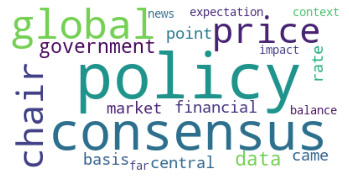

In [65]:
draw_wordcloud(lda, topic_number)

<AxesSubplot:xlabel='word'>

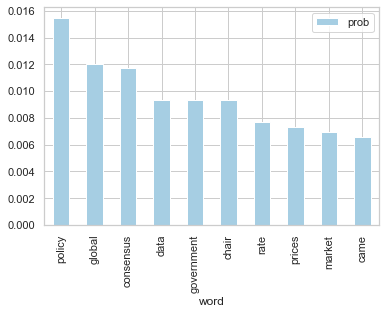

In [66]:
# Plot a bar chart using the most probable topic and the scores
df_topic = pd.DataFrame(lda.show_topic(topic_number,topn=10),columns = ["word", "prob"])
df_topic.plot.bar(x = "word", y = "prob")

### LDA for Past-year data

In [67]:
story_list_year = []
for i in range(len(user_ids)):
    story_list_year.append(build_texts(user_ids[i], df_metrics_year_active))

In [68]:
# Join tweet texts posted by the same author and form a list of documents
for i in range(len(story_list_year)):
    story_year = story_list_year[i]
    sents_year = sent_tokenize(story_year)
    for j in range(len(sents_year)):
        sent_year = sents_year[j]
        sent_year = sent_year.strip().replace('\n','')
        sent_year = sent_year.replace('\n\n','')
        sent_year = sent_year.replace('RT ', '')
        sents_year[j] = sent_year
    story_list_year[i] = ' '.join(sents_year)

In [69]:
# Some simple data cleaning
texts_year = [[word for word in story_year.lower().split()
               if word not in STOPWORDS and word.isalnum()]
               for story_year in story_list_year]

In [70]:
dictionary_year = corpora.Dictionary(texts_year) #(word_id,word) pairs
corpus_year = [dictionary_year.doc2bow(text) for text in texts_year] #(word_id,freq) pairs by sentence

In [71]:
# Set parameters
num_topics = 3 # The number of topics that should be generated
passes = 10

In [72]:
# Construct the LDA model
lda_year = LdaModel(corpus_year,
                    id2word=dictionary_year,
                    num_topics=num_topics,
                    passes=passes)

In [73]:
# Print topics
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda_year.print_topics(num_words=8))

[   (   0,
        '0.012*"bitcoin" + 0.009*"inflation" + 0.009*"fed" + 0.008*"gold" + '
        '0.008*"price" + 0.007*"prices" + 0.007*"money" + 0.006*"buy"'),
    (   1,
        '0.011*"policy" + 0.008*"inflation" + 0.008*"market" + 0.006*"good" + '
        '0.006*"financial" + 0.005*"global" + 0.005*"economic" + '
        '0.005*"government"'),
    (   2,
        '0.005*"energy" + 0.004*"space" + 0.004*"continue" + 0.004*"pod" + '
        '0.004*"new" + 0.004*"like" + 0.004*"people" + 0.004*"want"')]


In [74]:
# Find out the most important topic
from operator import itemgetter
lda_year.get_document_topics(corpus_year[0],minimum_probability=0.05,per_word_topics=False)
list_topic_rank_year = sorted(lda_year.get_document_topics(corpus_year[0],minimum_probability=0,per_word_topics=False),
                              key=itemgetter(1),reverse=True)

topic_number_year = list_topic_rank_year[0][0]
topic_number_year

1

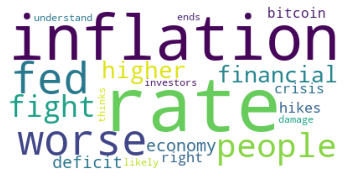

In [75]:
draw_wordcloud(lda, topic_number_year)

<AxesSubplot:xlabel='word'>

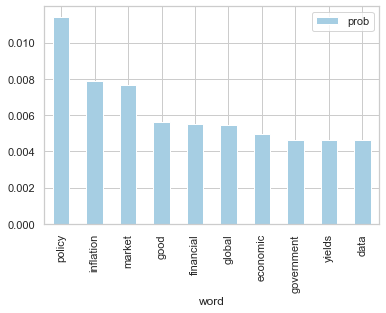

In [76]:
# Plot a bar chart using the most probable topic and the scores
df_topic_year = pd.DataFrame(lda_year.show_topic(topic_number_year,topn=10),columns = ["word", "prob"])
df_topic_year.plot.bar(x = "word", y = "prob")